In [20]:
# Cell 1: Setup & Dependencies
import os
from pathlib import Path
import base64
from io import BytesIO
from typing import Dict, List, Tuple, Optional
import json
from IPython.display import display, Image as IPImage, SVG as IPSVG, HTML

# OpenAI
from openai import OpenAI
from dotenv import load_dotenv

# SVG/Image handling
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import xml.etree.ElementTree as ET

# Load environment variables
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

# Create output directories
output_dir = Path("pngs")
output_dir.mkdir(exist_ok=True)

svg_output_dir = Path("svgs")
svg_output_dir.mkdir(exist_ok=True)

print("✓ Setup complete!")
print(f"✓ API Key loaded: {api_key[:20]}...")
print(f"✓ PNG output directory: {output_dir}")
print(f"✓ SVG output directory: {svg_output_dir}")


✓ Setup complete!
✓ API Key loaded: sk-proj-h3xI9__XETXj...
✓ PNG output directory: pngs
✓ SVG output directory: svgs


In [21]:
# Cell 2: SVG Generator Function
def generate_svg(
    prompt: str, 
    feedback: Optional[Dict] = None, 
    previous_svg: Optional[str] = None,
    iteration: int = 1
) -> str:
    """
    Generate SVG code using OpenAI API.
    
    Args:
        prompt: User's text description
        feedback: Dictionary with good_elements, bad_elements, and suggestions
        previous_svg: Previous iteration's SVG code (if any)
        iteration: Current iteration number
    
    Returns:
        SVG code as string
    """
    
    # Build system message with constraints
    system_msg = """You are an expert SVG generator for a plotting robot that draws with sauce.

CRITICAL CONSTRAINTS:
- Output ONLY valid SVG code (starting with <svg> tag)
- Use STROKES ONLY, no fills (or fill="none")
- All paths must have stroke="#000" and stroke-width between 1-3
- SVG viewBox should be "0 0 220 220" (220mm x 220mm plate)
- Maximum 100 paths total
- No features smaller than 2mm
- Simple, clean line art suitable for single-stroke plotting
- Use basic shapes: circles, ellipses, paths, lines
- Avoid complex transforms or nested groups
- Keep total path length under 3 meters
- Design should be centered in the viewBox

OUTPUT FORMAT:
Return ONLY the SVG code, no explanations or markdown formatting.
Start directly with: <svg xmlns="http://www.w3.org/2000/svg" ...>
"""
    
    # Build user message
    if iteration == 1 or previous_svg is None:
        # First iteration - generate from scratch
        user_msg = f"Create an SVG drawing of: {prompt}\n\n"
    else:
        # Subsequent iterations - iterative improvement
        user_msg = f"Improve this SVG drawing of '{prompt}' by fixing specific issues while preserving what works.\n\n"
        user_msg += f"CURRENT SVG CODE:\n```svg\n{previous_svg}\n```\n\n"
        
        if feedback:
            if feedback.get("good_elements"):
                user_msg += f"✅ KEEP THESE (they work well):\n"
                for elem in feedback["good_elements"]:
                    user_msg += f"  - {elem}\n"
                user_msg += "\n"
            
            if feedback.get("bad_elements"):
                user_msg += f"❌ FIX THESE (they need improvement):\n"
                for elem in feedback["bad_elements"]:
                    user_msg += f"  - {elem}\n"
                user_msg += "\n"
            
            if feedback.get("suggestions"):
                user_msg += f"💡 SPECIFIC IMPROVEMENTS:\n"
                for suggestion in feedback["suggestions"]:
                    user_msg += f"  - {suggestion}\n"
                user_msg += "\n"
        
        user_msg += "Return the COMPLETE improved SVG with good elements preserved and bad elements fixed."
    
    # Combine system and user messages for GPT-5.1
    full_input = f"{system_msg}\n\n{user_msg}"
    
    # Call OpenAI API with GPT-5.1 responses format
    response = client.responses.create(
        model="gpt-5.1",
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": full_input}
                ]
            }
        ],
        reasoning={"effort": "high"}
    )
    
    svg_code = response.output_text.strip()
    
    # Extract SVG if wrapped in markdown code blocks
    if svg_code.startswith("```"):
        lines = svg_code.split("\n")
        svg_code = "\n".join(lines[1:-1]) if len(lines) > 2 else svg_code
        svg_code = svg_code.replace("```svg", "").replace("```", "").strip()
    
    return svg_code

print("✓ SVG Generator function ready!")


✓ SVG Generator function ready!


In [22]:
# Cell 3: SVG to PNG Converter Function
def svg_to_png(svg_code: str, output_path: Optional[Path] = None, size: int = 512) -> bytes:
    """
    Convert SVG string to PNG image.
    
    Args:
        svg_code: SVG code as string
        output_path: Optional path to save PNG file
        size: Output image size in pixels
    
    Returns:
        PNG image as bytes
    """
    try:
        # Save SVG to temporary file
        temp_svg = Path("temp_gen.svg")
        temp_svg.write_text(svg_code)
        
        # Convert using svglib
        drawing = svg2rlg(str(temp_svg))
        
        # Render to PNG in memory
        img_data = BytesIO()
        renderPM.drawToFile(drawing, img_data, fmt="PNG")
        img_bytes = img_data.getvalue()
        
        # Optionally save to file
        if output_path:
            output_path.write_bytes(img_bytes)
        
        # Clean up temp file
        temp_svg.unlink()
        
        return img_bytes
        
    except Exception as e:
        print(f"Error converting SVG to PNG: {e}")
        # Clean up on error
        if temp_svg.exists():
            temp_svg.unlink()
        raise

print("✓ SVG to PNG converter function ready!")


✓ SVG to PNG converter function ready!


In [23]:
# Cell 4: Critic/Judge Function
def judge_image(png_bytes: bytes, original_prompt: str) -> Dict:
    """
    Use OpenAI Vision API to critique the generated image.
    
    Args:
        png_bytes: PNG image as bytes
        original_prompt: Original user prompt for context
    
    Returns:
        Dictionary with score, pass status, issues, and suggestions
    """
    
    # Encode image to base64
    img_b64 = base64.b64encode(png_bytes).decode('utf-8')
    
    # Build rubric message with weighted scoring (aesthetics and legibility more important)
    rubric_msg = f"""You are an expert critic evaluating SVG line art for a sauce-plotting robot.

The user requested: "{original_prompt}"

Rate the image on these criteria (WEIGHTED SCORING - total max 30):

1. LEGIBILITY (0-10): Does it look like "{original_prompt}"? Is the subject immediately recognizable and clear? This is MOST IMPORTANT.
2. AESTHETICS (0-10): Does it look good? Proper proportions, good composition, visually appealing? VERY IMPORTANT.
3. STROKE CONTINUITY (0-5): Are lines smooth and connected? Minimal gaps?
4. PRINTABILITY (0-5): Suitable for single-stroke plotting? No tiny details or overlaps?

PASSING SCORE: 24/30 (80%)

Respond ONLY with valid JSON in this exact format:
{{
    "legibility": <0-10>,
    "aesthetics": <0-10>,
    "stroke_continuity": <0-5>,
    "printability": <0-5>,
    "total_score": <sum of above>,
    "pass": <true if >= 24, else false>,
    "good_elements": ["element 1 that works well", "element 2 that works well", ...],
    "bad_elements": ["element 1 that needs fixing", "element 2 that needs fixing", ...],
    "issues": ["issue 1", "issue 2", ...],
    "suggestions": ["specific suggestion 1 for fixing bad elements", "suggestion 2", ...]
}}

IMPORTANT: Be specific about which parts/elements are good (to preserve) vs bad (to fix).
Focus on actionable feedback that helps improve the design iteratively."""

    # Call OpenAI Vision API with GPT-5.1 responses API
    # The responses API supports multimodal inputs including images
    response = client.responses.create(
        model="gpt-5.1",
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": rubric_msg},
                    {
                        "type": "input_image",
                        "image_url": f"data:image/png;base64,{img_b64}"
                    }
                ]
            }
        ],
        reasoning={"effort": "medium"}
    )
    result_text = response.output_text.strip()
    
    # Extract JSON if wrapped in markdown
    if result_text.startswith("```"):
        lines = result_text.split("\n")
        result_text = "\n".join(lines[1:-1]) if len(lines) > 2 else result_text
        result_text = result_text.replace("```json", "").replace("```", "").strip()
    
    # Parse JSON
    try:
        result = json.loads(result_text)
        return result
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON response: {e}")
        print(f"Raw response: {result_text}")
        # Return a fallback result
        return {
            "legibility": 0,
            "stroke_continuity": 0,
            "printability": 0,
            "aesthetics": 0,
            "total_score": 0,
            "pass": False,
            "issues": ["Failed to parse critic response"],
            "suggestions": ["Retry generation"]
        }

print("✓ Critic/Judge function ready!")


✓ Critic/Judge function ready!


In [24]:
# Cell 5: Main Orchestration Loop
def generate_with_feedback(prompt: str, max_iterations: int = 6, passing_score: int = 24) -> Dict:
    """
    Main generator-critic loop.
    
    Args:
        prompt: User's text description
        max_iterations: Maximum number of iterations
        passing_score: Score threshold to pass (out of 30, default 24 = 80%)
    
    Returns:
        Dictionary with best result and all iteration history
    """
    
    print(f"🎨 Starting generator-critic loop for: '{prompt}'")
    print(f"📊 Target: {passing_score}/30 | Max iterations: {max_iterations}\n")
    
    best_result = None
    best_score = -1
    iterations_history = []
    feedback_dict = None
    previous_svg = None
    
    for i in range(1, max_iterations + 1):
        print(f"{'='*60}")
        print(f"🔄 ITERATION {i}/{max_iterations}")
        print(f"{'='*60}")
        
        # Generate SVG
        print("🎨 Generating SVG...")
        if i == 1:
            print("   Creating initial design from scratch...")
        else:
            print("   Iteratively improving previous design...")
        try:
            svg_code = generate_svg(
                prompt, 
                feedback=feedback_dict, 
                previous_svg=previous_svg,
                iteration=i
            )
            print(f"✓ Generated {len(svg_code)} characters of SVG code")
        except Exception as e:
            print(f"❌ Generation failed: {e}")
            continue
        
        # Convert to PNG
        print("🖼️  Converting to PNG...")
        try:
            png_path = output_dir / f"iter_{i:02d}.png"
            png_bytes = svg_to_png(svg_code, output_path=png_path)
            print(f"✓ Saved to {png_path}")
        except Exception as e:
            print(f"❌ Conversion failed: {e}")
            continue
        
        # Judge the image
        print("👨‍⚖️ Evaluating with critic...")
        try:
            critique = judge_image(png_bytes, prompt)
            score = critique.get("total_score", 0)
            passed = critique.get("pass", False)
            
            print(f"\n📊 SCORES:")
            print(f"   Legibility: {critique.get('legibility', 0)}/10 ⭐ (weighted)")
            print(f"   Aesthetics: {critique.get('aesthetics', 0)}/10 ⭐ (weighted)")
            print(f"   Stroke Continuity: {critique.get('stroke_continuity', 0)}/5")
            print(f"   Printability: {critique.get('printability', 0)}/5")
            print(f"   TOTAL: {score}/30 {'✅ PASS' if passed else '❌ FAIL'}")
            
            if critique.get("good_elements"):
                print(f"\n✅ Good Elements (to preserve):")
                for elem in critique["good_elements"]:
                    print(f"   - {elem}")
            
            if critique.get("bad_elements"):
                print(f"\n❌ Bad Elements (to fix):")
                for elem in critique["bad_elements"]:
                    print(f"   - {elem}")
            
            if critique.get("issues"):
                print(f"\n🔍 Issues:")
                for issue in critique["issues"]:
                    print(f"   - {issue}")
            
            if critique.get("suggestions"):
                print(f"\n💡 Suggestions for next iteration:")
                for suggestion in critique["suggestions"]:
                    print(f"   - {suggestion}")
            
            # Store structured feedback for next iteration
            feedback_dict = {
                "good_elements": critique.get("good_elements", []),
                "bad_elements": critique.get("bad_elements", []),
                "suggestions": critique.get("suggestions", [])
            }
            
        except Exception as e:
            print(f"❌ Critique failed: {e}")
            score = 0
            passed = False
            critique = {}
        
        # Track this iteration
        iteration_data = {
            "iteration": i,
            "svg_code": svg_code,
            "png_path": str(png_path),
            "score": score,
            "passed": passed,
            "critique": critique
        }
        iterations_history.append(iteration_data)
        
        # Update best result
        if score > best_score:
            best_score = score
            best_result = iteration_data
            print(f"\n⭐ New best score: {score}/30")
        
        # Display image in notebook
        print(f"\n📸 Preview:")
        display(IPImage(png_bytes))
        
        # Store current SVG for next iteration's improvement
        previous_svg = svg_code
        
        # Check if we passed
        if passed and score >= passing_score:
            print(f"\n🎉 SUCCESS! Reached passing score in {i} iterations!")
            break
        
        print(f"\n")
    
    # Final summary
    print(f"\n{'='*60}")
    print(f"🏁 FINAL RESULTS")
    print(f"{'='*60}")
    print(f"Best score: {best_score}/30")
    print(f"Best iteration: {best_result['iteration']}")
    print(f"Total iterations: {len(iterations_history)}")
    
    # Save best SVG to svgs directory
    best_svg_path = svg_output_dir / "best_result.svg"
    best_svg_path.write_text(best_result["svg_code"])
    print(f"\n✓ Best SVG saved to: {best_svg_path}")
    
    return {
        "best": best_result,
        "history": iterations_history,
        "final_score": best_score
    }

print("✓ Main orchestration loop ready!")


✓ Main orchestration loop ready!


In [ ]:
# Cell 6: Test with Example Prompt
# Run this cell to test the generator-critic loop!
# 
# How it works:
# - Iteration 1: Generates from scratch
# - Iteration 2+: Keeps good elements, fixes only bad elements (iterative improvement)

# Example prompt - feel free to change this
test_prompt = "a chinese dragon flying through the clouds"

# Run the loop
result = generate_with_feedback(
    prompt=test_prompt,
    max_iterations=6,
    passing_score=24  # 24/30 = 80% (weighted scoring emphasizes legibility and aesthetics)
)

# Display best result again
print("\n" + "="*60)
print("BEST RESULT PREVIEW")
print("="*60)
display(IPImage(result["best"]["png_path"]))


🎨 Starting generator-critic loop for: 'a chinese dragon flying through the clouds'
📊 Target: 24/30 | Max iterations: 6

🔄 ITERATION 1/6
🎨 Generating SVG...
   Creating initial design from scratch...


ALL ITERATIONS COMPARISON

Iteration 1: Score 18/30


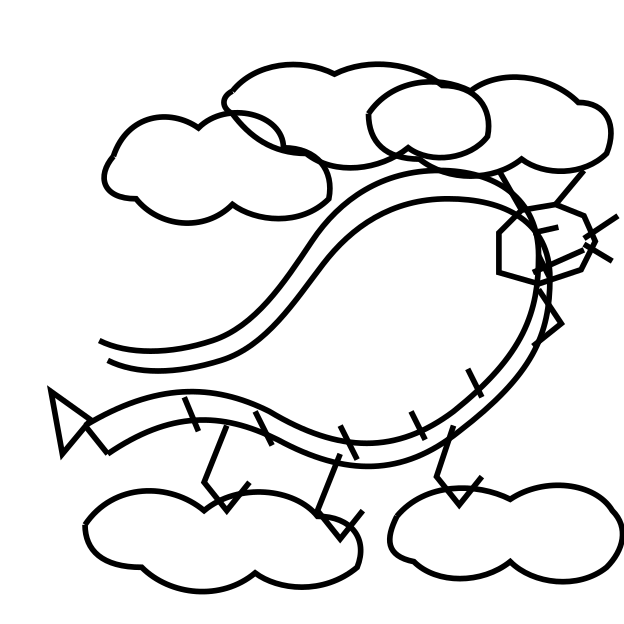

----------------------------------------

Iteration 2: Score 13/30


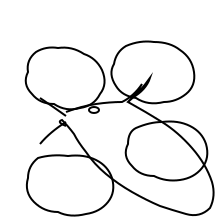

----------------------------------------

Iteration 3: Score 14/30


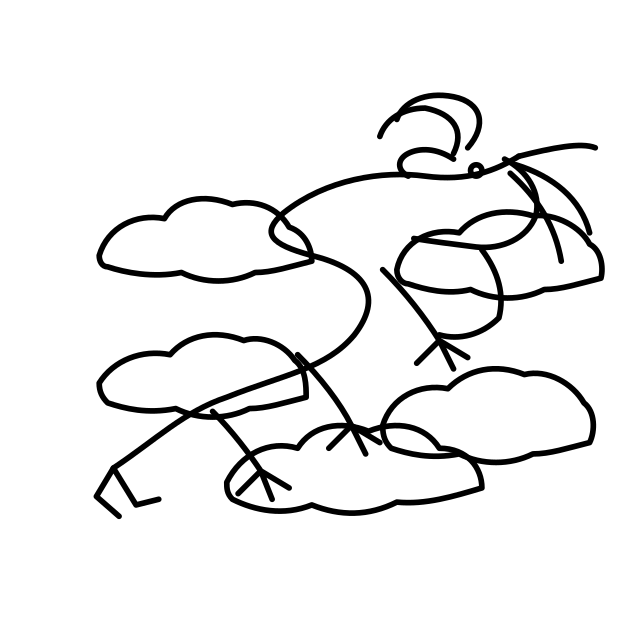

----------------------------------------

Iteration 4: Score 15/30


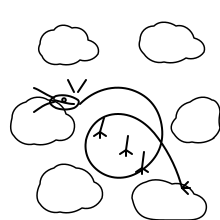

----------------------------------------

Iteration 5: Score 14/30


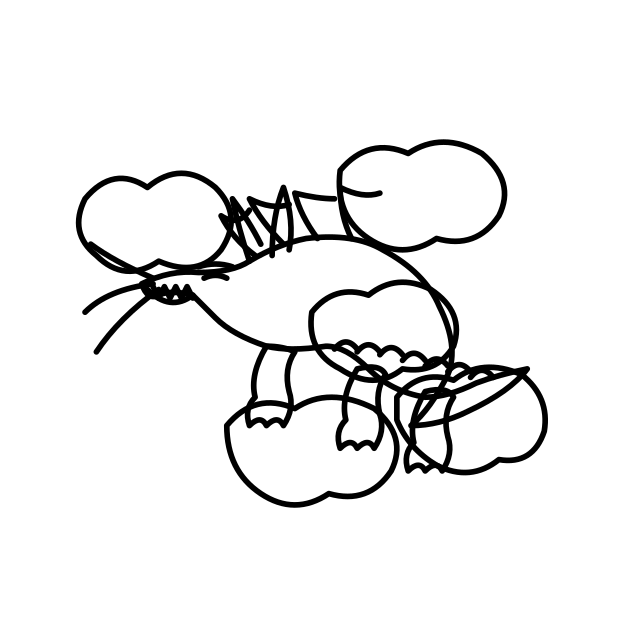

----------------------------------------

Iteration 6: Score 11/30


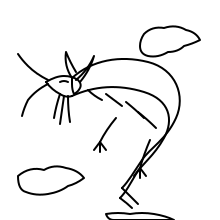

----------------------------------------


In [ ]:
# Cell 7: Helper - View All Iterations
# Run this cell to see all iterations from the last run side-by-side

def display_all_iterations(result: Dict):
    """Display all iterations from a result."""
    
    print("="*60)
    print("ALL ITERATIONS COMPARISON")
    print("="*60)
    
    for iter_data in result["history"]:
        print(f"\nIteration {iter_data['iteration']}: Score {iter_data['score']}/30")
        if iter_data.get('png_path'):
            display(IPImage(iter_data['png_path']))
        print("-" * 40)

# Uncomment to view all iterations from last run:
display_all_iterations(result)


# SVG Generator with Generator-Critic Loop

## Overview
This notebook implements an AI-powered SVG generator with **iterative improvement** using OpenAI's GPT-5.1 and Vision APIs.

## Pipeline
1. **Generator**: GPT-5.1 generates initial SVG from text prompt
2. **Converter**: SVG → PNG using svglib
3. **Critic**: GPT-5.1 Vision analyzes the PNG and identifies what's good vs what needs fixing
4. **Iterative Improvement**: Generator preserves good elements and only fixes bad elements
5. **Loop**: Repeats up to 6 iterations or until passing score (24/30) is reached

## Key Innovation: Iterative Refinement
Unlike traditional regeneration, this approach:
- **Preserves** elements that work well (identified by critic)
- **Only fixes** elements that need improvement
- **Converges** toward better results without losing progress

## Setup Requirements
Make sure you have a `.env` file in the project root with:
```
OPENAI_API_KEY=your_api_key_here
```

## Scoring Rubric (Weighted)
- **Legibility: 0-10 points ⭐ (Does it look like what it's supposed to be?)**
- **Aesthetics: 0-10 points ⭐ (Does it look good? Proper proportions?)**
- Stroke Continuity: 0-5 points
- Printability: 0-5 points
- **Total: 30 points (Pass: ≥24 = 80%)**

## Feedback Structure
For each iteration, the critic provides:
- ✅ **Good Elements**: Parts that work well (to preserve)
- ❌ **Bad Elements**: Parts that need fixing
- 💡 **Specific Suggestions**: How to fix the bad elements

## Usage
1. Run cells 1-5 to load all functions
2. Modify the prompt in Cell 6
3. Run Cell 6 to start the generation loop
4. PNG iterations saved to `pngs/` directory
5. Final best SVG saved to `svgs/` directory
